In [ ]:
#Import and declare TIC

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from scipy.interpolate import make_interp_spline as spline
import scipy.signal as signal

# plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 337646214'




In [2]:
#Download the data and stitch it together

search_results = lk.search_lightcurve(TIC, cadence='short')

used_result = search_results[0:3]
lc = used_result.download_all().stitch()

used_result

type(lc)


lightkurve.lightcurve.TessLightCurve

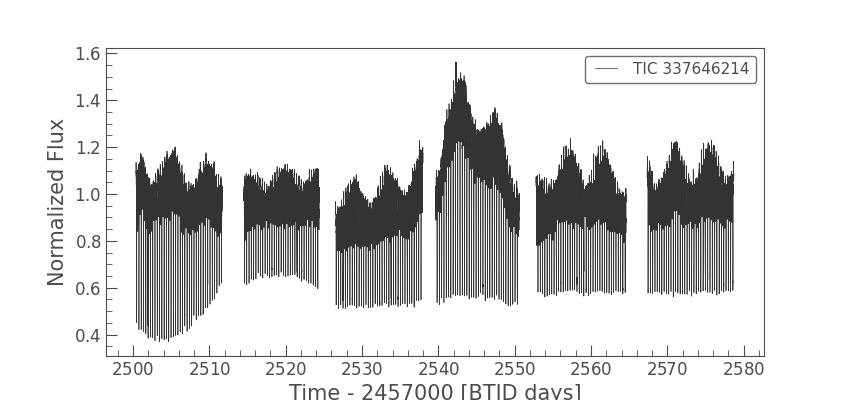

In [4]:
#Fills in all the gaps with straight lines

lc.plot()

#Setting up the arrays
time = np.array(lc.time.btjd)
cadence_multiplier = 86400/(np.median(np.diff(time[0:100])) * 86400).round()
time = (time - time[0]) * cadence_multiplier
time = time.round(0)
flux = np.array(lc.flux, dtype=float)
lightcurvepd = pd.DataFrame({'Time':time, 'Flux':flux})

#Filling in missing times with nans
time_interval = 1
min_time = time[0]
max_time = time[-1]
full_time = np.arange(min_time, max_time + time_interval, time_interval)
lightcurvepd.set_index('Time', inplace=True)
lightcurvepd = lightcurvepd.reindex(full_time)

#Filling in the Nans by interpolation
lightcurvepd['Flux'].interpolate(method='linear', inplace=True)

#reset index
lightcurvepd.reset_index(inplace=True)
lightcurvepd.rename(columns={'index':'Time'}, inplace=True)
lightcurvepd['Time'] = (lightcurvepd['Time'] / cadence_multiplier) + lc.time.btjd[0] + 2457000

lightcurvepd.dropna(inplace=True)
lightcurvepd.reset_index(inplace=True)


In [4]:
''' (DONT USE FOR NOW) '''
#Setting up the arrays and jumping over gaps (by filling them with a straight line)

#getting the indices of gap. 'r' = index of right point. 'l' = index of left point.
r = np.searchsorted(time, 1996, 'right')
l = r - 1

#getting the line equation
m = (flux[r] - flux[l]) / (time[r] - time[l])
c = - (m * time[l]) + flux[l]
x = np.linspace(time[l], time[r], 100)[1:-1]
y = m * x + c

#filling the gap with the line
fixed_time = np.concatenate((time[:l], x, time[r:]))
fixed_flux = np.concatenate((flux[:l], y, flux[r:]))

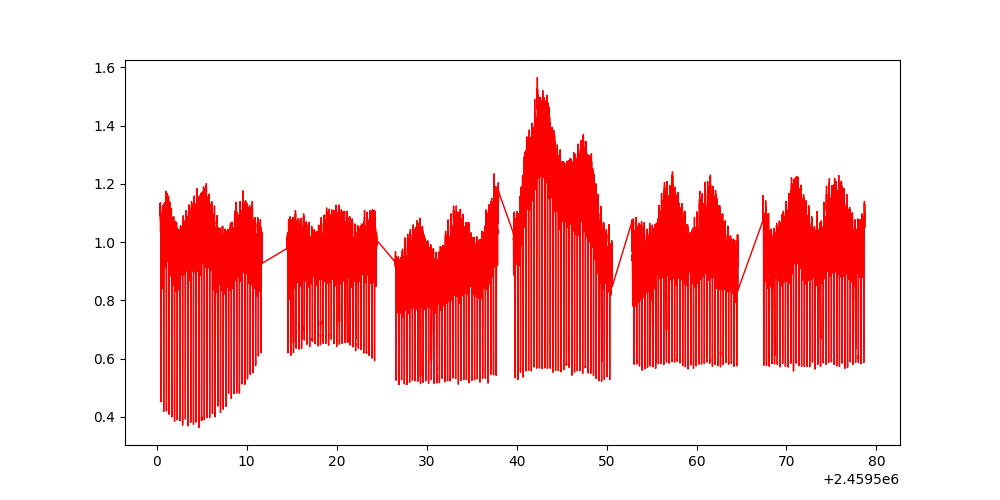

In [5]:
#Making the light curve smoother, with a spline interpolation (IN CASE OF NO GAPS)

time_smooth = np.linspace(lightcurvepd['Time'].min(), lightcurvepd['Time'].max(), 200000)
spl = spline(lightcurvepd['Time'], lightcurvepd['Flux'], k=3)
flux_smooth = spl(time_smooth)

#Plotting the splined lightcurve
plt.figure(figsize=(10, 5))
plt.plot(lightcurvepd['Time'], lightcurvepd['Flux'], lw = 0.3)
plt.plot(time_smooth, flux_smooth, 'r-', lw=1)

In [ ]:
'''Don't need to use for now'''
#Building the lightcurve again
final_lc = lk.LightCurve(time=time_smooth, flux=flux_smooth)

# f = final_lc.to_periodogram(method='bls').plot(color='red', lw=0.5)
g = lc.to_periodogram(method='ls').plot(view = 'period', color='black', lw=0.5)
final_lc.to_periodogram(method='ls').plot(view = 'period', color='blue', lw=0.5, ax=g)

[2459500.38211528 2459500.3825069  2459500.38289852 ... 2459578.70494315
 2459578.70533477 2459578.70572639]


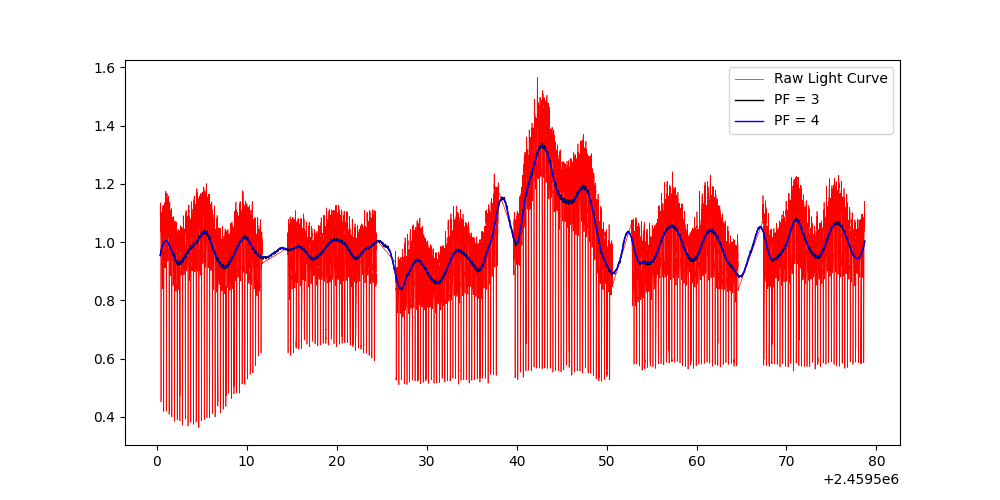

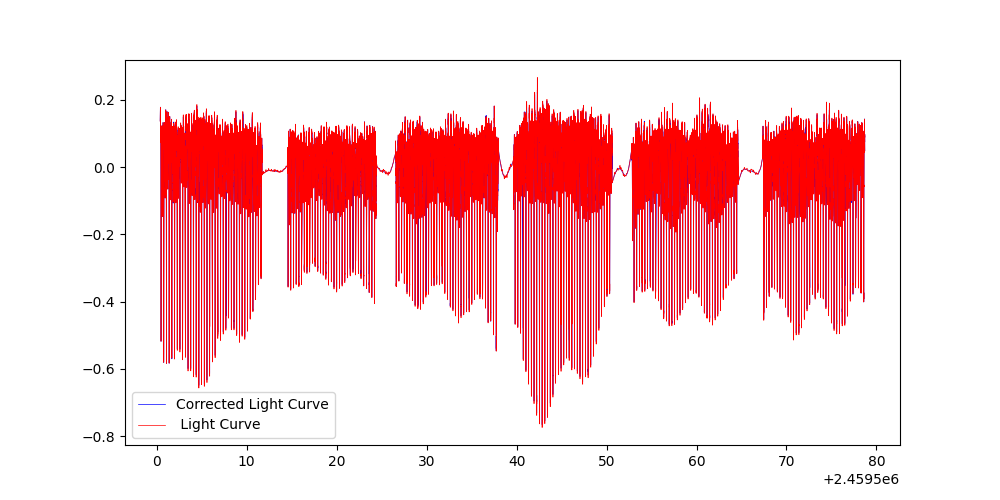

In [ ]:
#Applying the savgol filter and plotting (This part defines the function AND removes the big features)

def apply_savgol_filter(time_smooth, flux_smooth, window_length=2000):
    '''
    applies the savgol filter to 'flux_smooth' and 'time_smooth' with a 'window_length'
    
    returns the corrected lightcurve as lightkurve.LightCurve object and the regression curve itself
    '''
    if window_length == 2000:  #Removing the outburst and other large features
        flx = signal.savgol_filter(flux_smooth, 7500, 4 )
        flx2 = signal.savgol_filter(flx, 5000, 4)
        # flx3 = signal.savgol_filter(flux_smooth, 7000, 4)

        #plotting the savgol
        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth, 'r-', lw=0.5, label='Raw Light Curve')
        plt.plot(time_smooth, flx, 'k-', lw =1, label='PF = 3')
        plt.plot(time_smooth, flx2, 'b-', lw=1, label='PF = 4')
        # plt.plot(time_smooth, flx3, 'g-', lw=1, label='PF = 4, with 7000 window length')
        plt.legend()

        #plotting the processed graph
        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth - flx2, 'b-', lw=0.5, label='Corrected Light Curve')
        plt.plot(time_smooth, flux_smooth - flx, 'r-', lw=0.5, label=' Light Curve')
        plt.legend()

        #Building the lightcurve again, with the correction
        print(time_smooth)
        return lk.LightCurve(time=time_smooth, flux=flux_smooth - flx2)

    else:  #Finding the gaussians techincally
        flx2 = signal.savgol_filter(flux_smooth, window_length, 4)
        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth, 'r-', lw=0.5, label='Raw Light Curve')
        # plt.plot(time_smooth, flx, 'k-', lw =1, label='PF = 3')
        plt.plot(time_smooth, flx2, 'k-', lw=1, label='PF = 4')
        # plt.plot(time_smooth, flx3, 'g-', lw=1, label='PF = 4, with 7000 window length')
        plt.legend()

        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth - flx2, 'b-', lw=0.5, label='Corrected Light Curve')

        #Building the lightcurve again, with the correction
        print(time_smooth)
        return (lk.LightCurve(time = time_smooth, flux=flux_smooth - flx2), lk.LightCurve(time = time_smooth, flux= -flx2))


corrected_lc = apply_savgol_filter(time_smooth, flux_smooth)


[2459500.38211528 2459500.3825069  2459500.38289852 ... 2459578.70494315
 2459578.70533477 2459578.70572639]


<Axes: xlabel='Time [JD]', ylabel='Flux'>

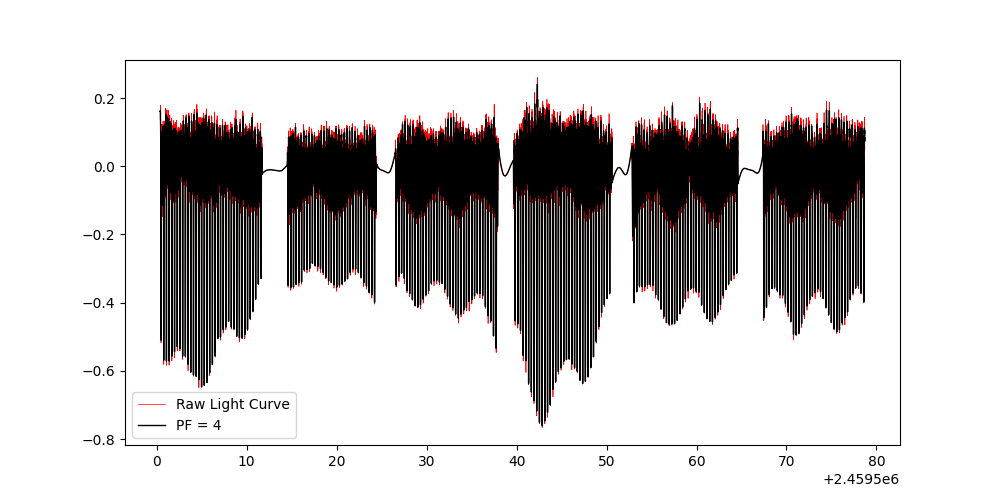

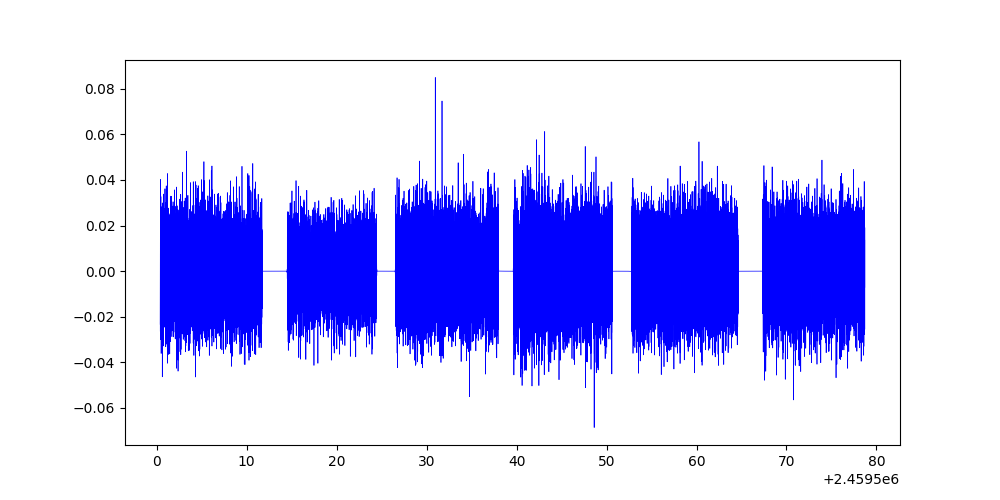

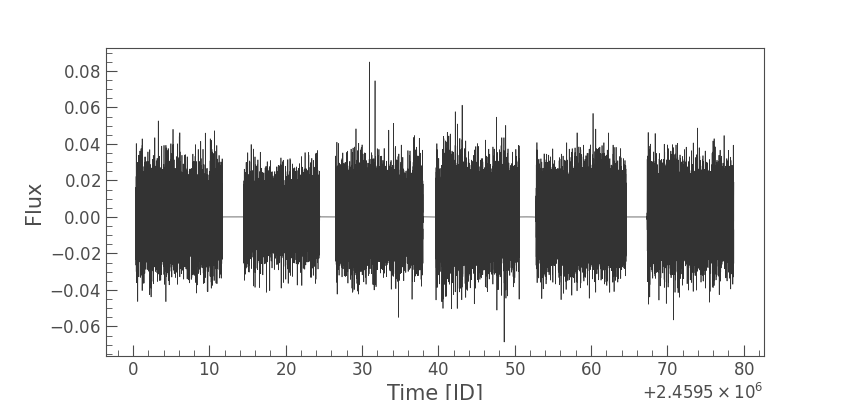

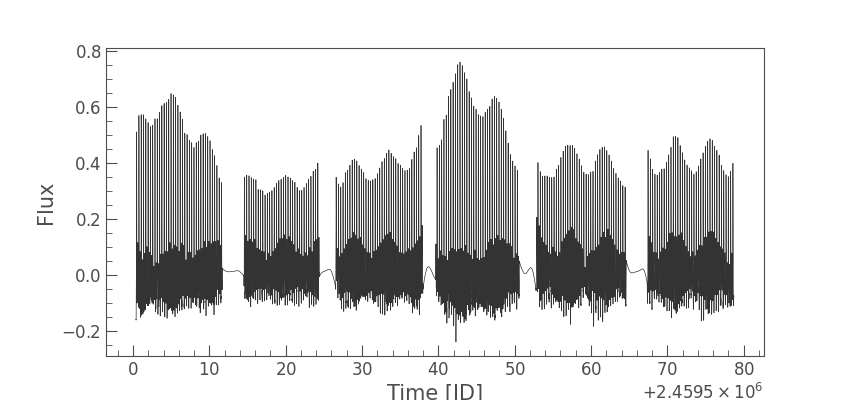

In [ ]:
#Find gaussians

new_ls = apply_savgol_filter(time_smooth, corrected_lc.flux, 100)
new_corrected = new_ls[0]
fitted = new_ls[1]


new_corrected.plot()
fitted.plot()

In [11]:
'''Don't need to use for now'''
bls = new_corrected.to_periodogram(method='bls')
bls = fitted.to_periodogram(method='bls')

planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power


planet_b_mask = bls.get_transit_mask(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)

masked_lc = fitted[~planet_b_mask]
ax = masked_lc.scatter()
fitted[planet_b_mask].scatter(ax=ax, c='r', label='Masked')

In [8]:
#Function for checking the differences in peaks and also O-C maker

def find_peak_diffs(fitted : lk.LightCurve, threshold, number_of_gaps = 10):
    '''
    Finds the peaks, differences, mean & median between the peaks of a locally-weighted-regression-ed lightcurve.

    Parameters:
    -----------
    `fitted` : `lightkurve.LightCurve` or `pd.Dataframe` with columns `'time'` and `'flux'` 
        The lightcurve that has been locally weighted regressed.
    `threshold` : `float`
        The threshold for the peak detection.
    `number_of_gaps` : `int`
        (default = 10)
        The aproximate number of gaps, always enter a much higher value than the true number.

    Returns:
    --------
    `mean_diff` : `float`
        The mean difference between the peaks.
    `median_diff` : `float`
        The median difference between the peaks.
    `peak_times` : `numpy.ndarray`
        The times of the peaks.
    `peak_differences` : `numpy.ndarray`
        The differences between the peaks.
    '''

    import lightkurve as lk
    import pandas as pd
    from scipy.signal import find_peaks
    import numpy as np
    import matplotlib.pyplot as plt

    # Get the flux and time values
    if isinstance(fitted, lk.LightCurve):
        fl = np.array(fitted.flux)
        tm = np.array(fitted.time.btjd)
    if isinstance(fitted, pd.DataFrame):
        fl = np.array(fitted['flux'])
        tm = np.array(fitted['time'])

    # Find peaks in fl above threshold
    peaks, _ = find_peaks(fl, height=threshold)

    # Get the associated time values for the peaks
    peak_times = tm[peaks]

    # Print the peak times
    # plt.figure(figsize=(10, 5))
    # plt.plot(np.diff(peak_times), lw = 0, marker='.', markersize=1)
    # plt.show()

    mean_diff = np.sort(np.diff(peak_times))[:-10].mean()
    median_diff = np.median(np.sort(np.diff(peak_times))[:-10])

    return mean_diff, median_diff, peak_times, np.diff(peak_times)

def reject_outliers(data, m=1):
    removed = data[abs(data - np.mean(data)) > m * np.std(data)]
    print("Outliers Removed: ", len(removed))
    accepted = data[abs(data - np.mean(data)) < m * np.std(data)]
    plt.figure()
    plt.plot(accepted)
    return accepted

def reject_outliers_pd(data : pd.DataFrame, column_name : str, m=1):
    removed = data[abs(data[column_name] - np.mean(data[column_name])) > m * np.std(data[column_name])]
    print("Outliers Removed: ", len(removed))
    accepted = data[abs(data[column_name] - np.mean(data[column_name])) < m * np.std(data[column_name])]
    accepted.reset_index(inplace=True, drop=True)
    return accepted

def make_O_C(fitted):
    '''
    Makes the O-C diagram for a given lightcurve, period, t0 and duration.
    '''

    

Outliers Removed:  9


<Axes: xlabel='Time'>

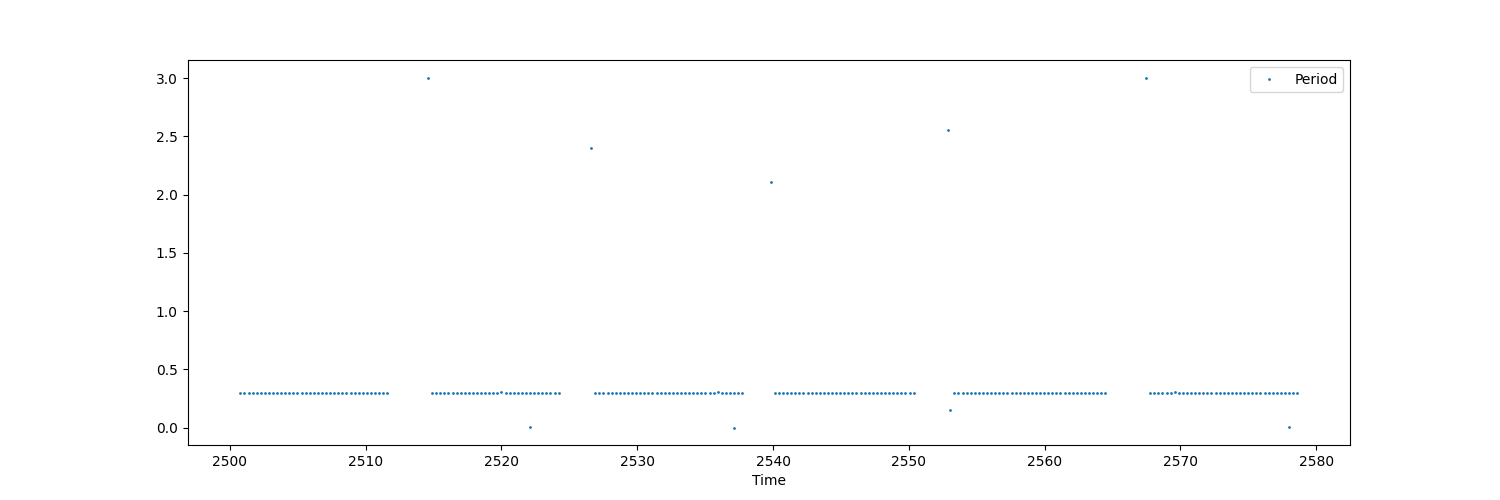

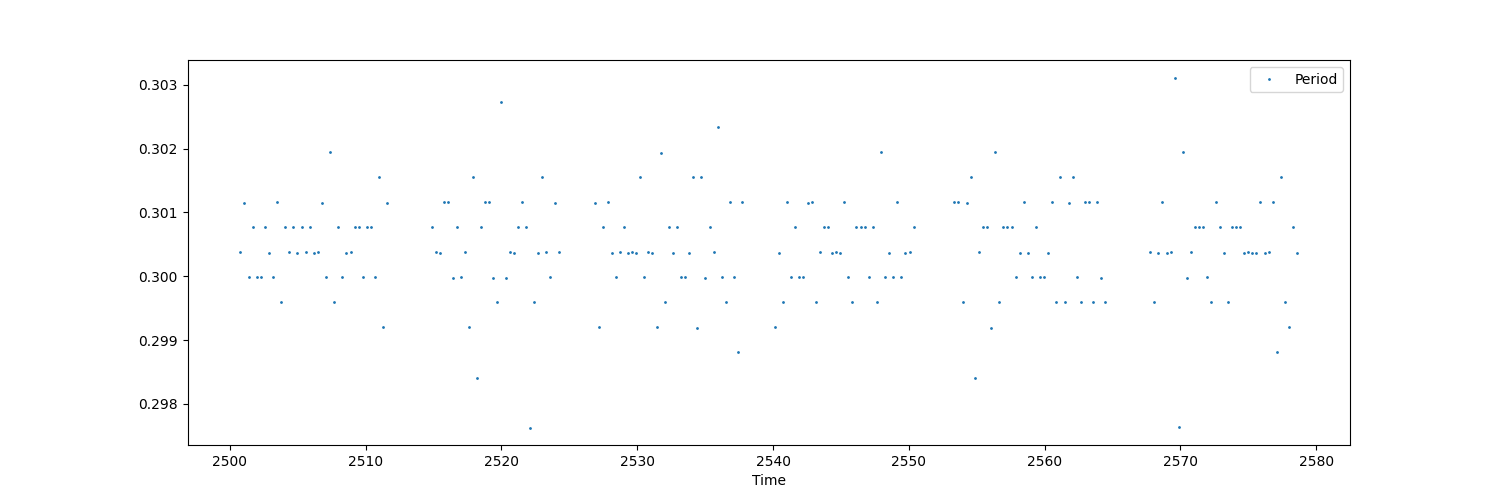

In [9]:
j, k = find_peak_diffs(fitted, 0.2)[2][1:], find_peak_diffs(fitted, 0.2)[3]
ac = pd.DataFrame({'Time':j, 'Period':k})
ac.plot(x = 'Time', y = 'Period', lw = 0, marker = 'o', markersize = 1, figsize=(15, 5))
# Remove outliers from pd.DataFrame

accepted = reject_outliers_pd(ac, 'Period', 0.15)
accepted.plot(x = 'Time', y = 'Period', lw = 0, marker = 'o', markersize = 1, figsize=(15, 5))

/var/folders/dj/s7s773g53wg44p006fln3znw0000gn/T/ipykernel_38707/733564691.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  O_C['Predicted_O-C'] = predicted_values
/var/folders/dj/s7s773g53wg44p006fln3znw0000gn/T/ipykernel_38707/733564691.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  O_C['Residuals'] = O_C['O_C'] - O_C['Predicted_O-C']


0        0
1        1
2        2
3        3
4        4
      ... 
211    255
212    256
213    257
214    258
215    259
Name: E, Length: 216, dtype: int64

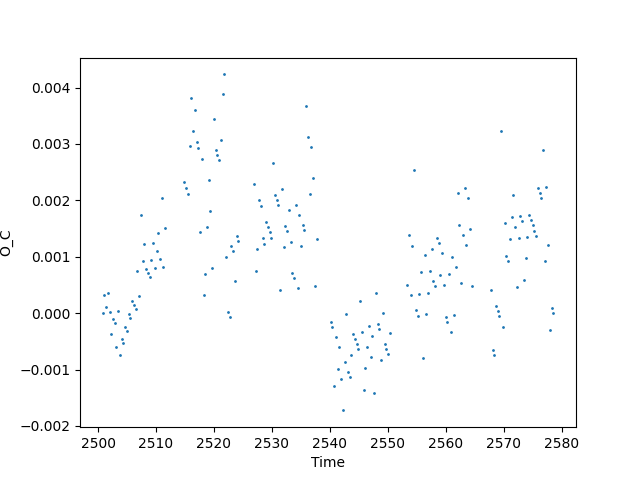

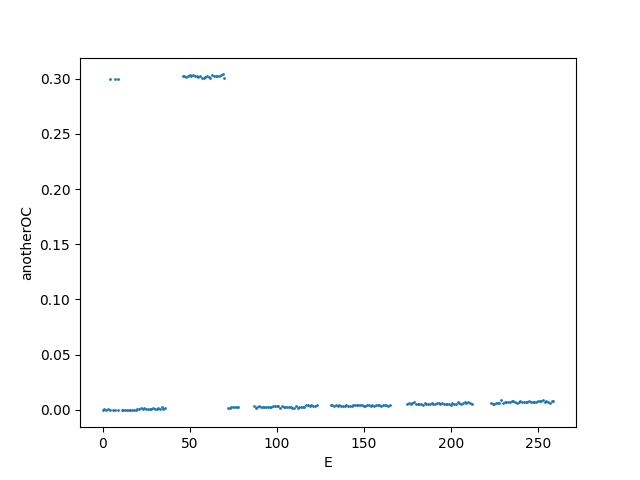

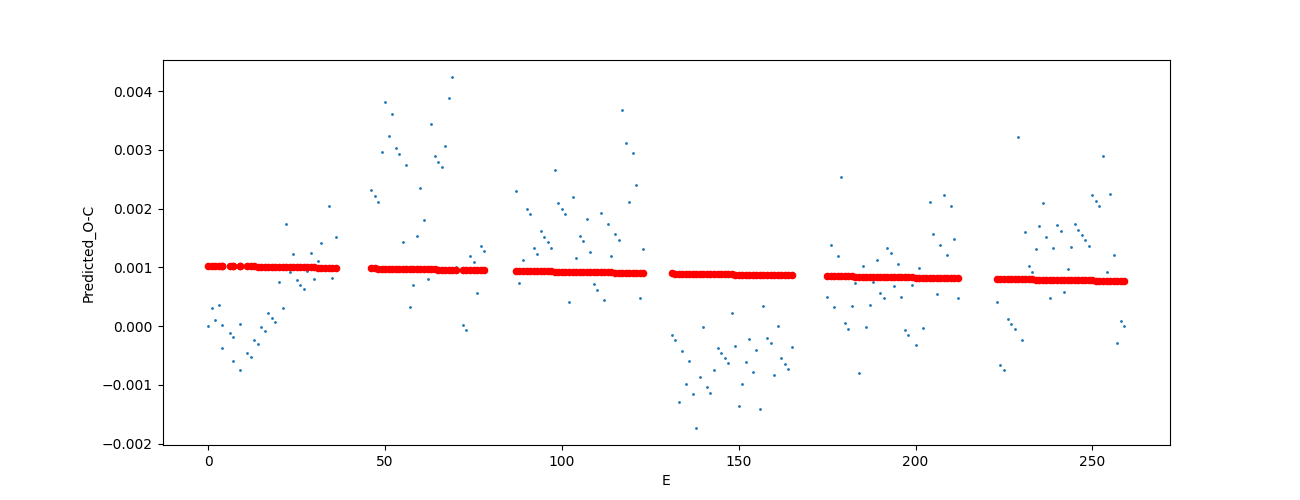

In [55]:
def make_OC(accepted : pd.DataFrame):
    '''
    Make an O-C diagram from a pandas DataFrame of accepted data.
    '''
    df = accepted.copy(deep=True)
    df['t'] = df['Time'] - df['Time'][0]
    p0 = (df['Period']).mean()
    # p0 = df['Period'][0]
    df['p_'] = [ ( df['Period'][:x].sum() / x ) for x in range(1, len(df) + 1)]
    df['E'] = df['t'] / df['p_']
    df['E'] = df['E'].astype(int)
    df['anotherOC'] = df['t'] - (p0 * df['E'])
    df['O_C'] = df['t'] * ( 1 - ( p0 / df['p_'] ) )
    return df

got = make_OC(accepted)
got.plot(x = 'Time', y = 'O_C', kind = 'scatter', s = 1)
got.plot(x = 'E', y = 'anotherOC', kind = 'scatter', s = 1)
O_C = got[['E', 'O_C']]

from sklearn.linear_model import LinearRegression

# Create the linear regression model
regression_model = LinearRegression()

# Fit the model to the data
regression_model.fit(O_C[['E']], O_C['O_C'])

# Get the predicted values
predicted_values = regression_model.predict(O_C[['E']])

# Add the predicted values to the DataFrame
O_C['Predicted_O-C'] = predicted_values

plotted_O_C = O_C.plot(x = 'E', y = 'O_C', kind = 'scatter', s = 1, figsize = (13, 5))
O_C.plot(x = 'E', y = 'Predicted_O-C', kind = 'scatter', ax = plotted_O_C, color = 'red')
O_C['Residuals'] = O_C['O_C'] - O_C['Predicted_O-C']
# O_C.plot(x = 'E', y = 'Residuals', kind = 'scatter', s = 1, figsize = (13, 5), ax = plotted_O_C, color = 'green')

# t_sm = np.linspace(O_C['E'].min(), O_C['E'].max(), len(O_C['E']) * 2)
# spl = spline(O_C['E'], O_C['O_C'], k=2)
# O_C_new = spl(t_sm)
# plt.plot(t_sm, O_C_new, 'r', lw=0.5, axes = plotted_O_C)


O_C['E']





In [67]:
j = pd.DataFrame({
    'a': [1, 2, 3],
    'b': [4, 5, 6]
})
j['c'] = [2, 3, 5]

j

,a,b,c
0,1,4,2
1,2,5,3
2,3,6,5


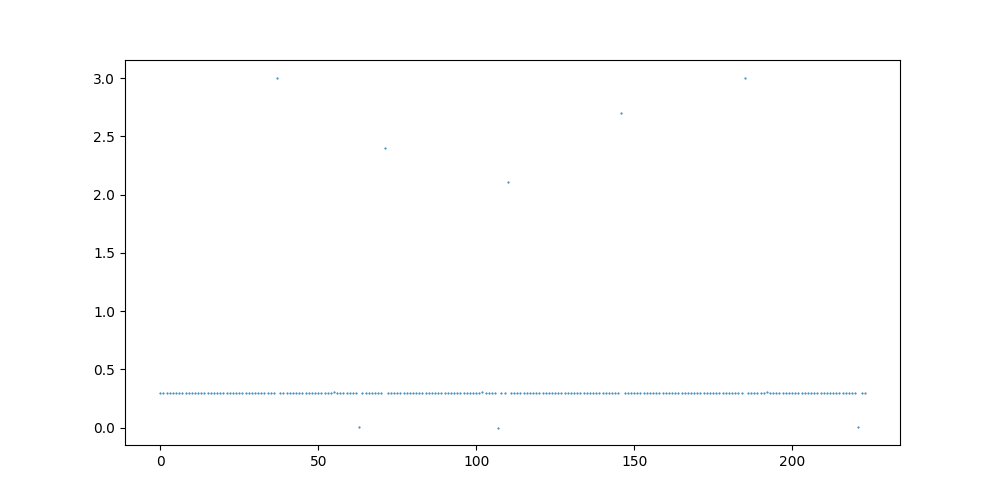

Outliers Removed:  8


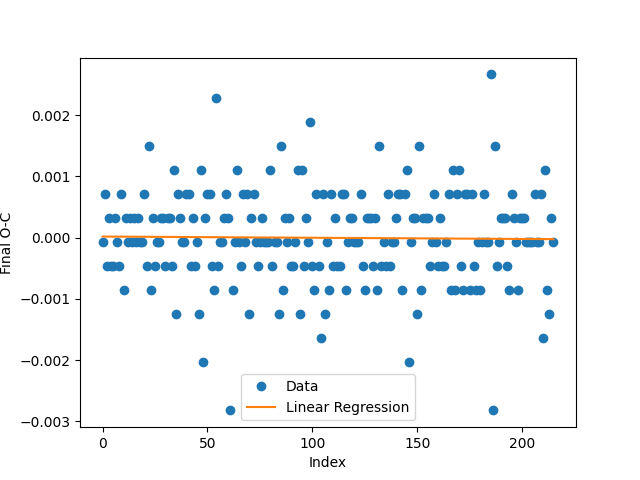

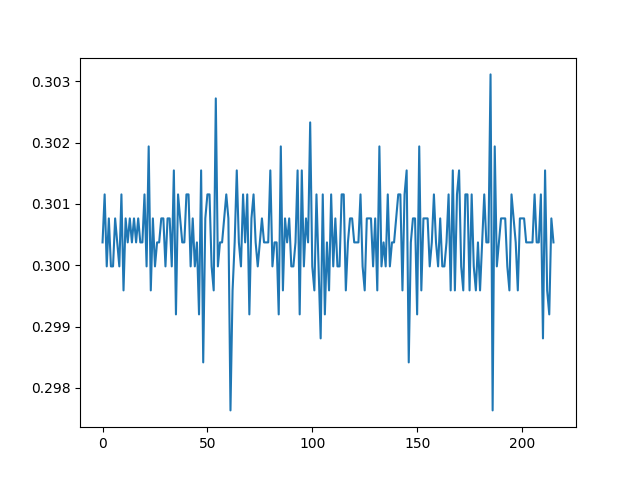

In [8]:
import numpy as np

periods = find_peak_diffs(fitted, 0.22, 10)[2]
removed_outliers_periods = reject_outliers(periods, 0.15)
final_o_c = removed_outliers_periods - removed_outliers_periods[:10].mean()
plt.figure()
import matplotlib.pyplot as plt

# Extract the x and y values from final_o_c
x = np.arange(len(final_o_c))
y = final_o_c

# Fit the linear regression
coefficients = np.polyfit(x, y, 1)
line = np.poly1d(coefficients)
y_fit = line(x)

# Plot the data and the linear regression line
plt.plot(x, y, 'o', label='Data')
plt.plot(x, y_fit, label='Linear Regression')
plt.xlabel('Index')
plt.ylabel('Final O-C')
plt.legend()
plt.show()
plt.plot(removed_outliers_periods - removed_outliers_periods[:10].mean(), marker = 'o', lw = 0, markersize = 2, color = 'black')

In [ ]:
import astropy.units as u

# new_corrected.fold(period = 0.0867846217006445, epoch_time = 10).bin(time_bin_size=0.05 * u.minute).scatter()
g = corrected_lc.fold(period = 0.08681421200146472).bin(time_bin_size=0.5 * u.minute).scatter()
corrected_lc.fold(period = 0.0867846217006445).bin(time_bin_size=0.5 * u.minute).scatter(ax=g, color='green')

In [ ]:
print(0.08681421200146472*86400, 0.0867846217006445*86400)

In [ ]:
corrected_lc.plot()
clc1 = corrected_lc.normalize().remove_nans().remove_outliers()
print(type(clc1))
clc2 = lk.correctors.SFFCorrector(clc1).correct(windows=10).remove_outliers().fill_gaps()
clc2.plot()